<a href="https://colab.research.google.com/github/garthajon/QuantFinanceIntro/blob/main/PutOptionPriceChangeProjection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
pip install yfinance

[*********************100%***********************]  1 of 1 completed
<ipython-input-6-f3d90cff04a2>:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return annualized_volatility, float(stock_data["Close"].iloc[-1])  # Return volatility and last closing price


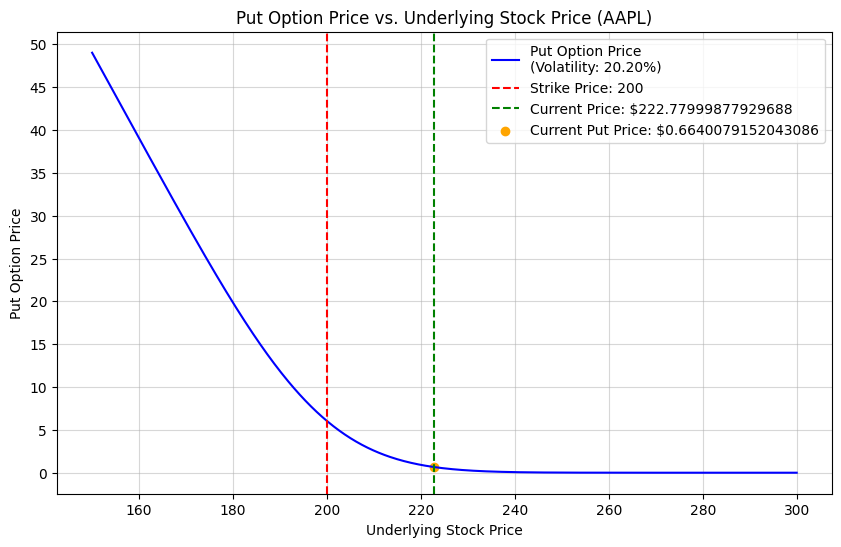

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf

def calculate_annualized_volatility(ticker, days=60):
    """
    Calculate the annualized volatility from historical stock prices.
    ticker: Stock ticker symbol (e.g., 'TSLA')
    days: Number of past trading days to consider for volatility calculation
    """
    # Fetch historical stock data from Yahoo Finance
    stock_data = yf.download(ticker, period=f"{days + 1}d", interval="1d")

    # Calculate daily log returns
    stock_data['Log Returns'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))

    # Calculate standard deviation of daily log returns
    daily_volatility = stock_data['Log Returns'].std()

    # Annualize the volatility
    annualized_volatility = daily_volatility * np.sqrt(252)  # Assuming 252 trading days in a year
    return annualized_volatility, float(stock_data["Close"].iloc[-1])  # Return volatility and last closing price

def black_scholes_put(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes price of a put option.
    S: Current stock price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free rate (as a decimal)
    sigma: Volatility (standard deviation of returns)
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

def plot_put_price_change_with_time(ticker, S_min, S_max, K, T_days, r):
    """
    Plot the change in put option price over a range of stock prices using actual annualized volatility.
    ticker: Stock ticker symbol (e.g., 'TSLA')
    S_min: Minimum projected stock price
    S_max: Maximum current stock price
    K: Strike price
    T_days: Time to maturity in days
    r: Risk-free rate (as a decimal)
    """
    # Calculate annualized volatility and get current stock price
    sigma, current_price = calculate_annualized_volatility(ticker)

    current_price = float(current_price)

    # Convert time to maturity to a fraction of a year
    T = T_days / 365.0

    # Generate a range of stock prices (falling scenario)
    stock_prices = np.linspace(S_min, S_max, 500)

    # Calculate the put option prices for each stock price
    put_prices = [black_scholes_put(S, K, T, r, sigma) for S in stock_prices]

    # Calculate the current put option price
    current_put_price = black_scholes_put(current_price, K, T, r, sigma)
    current_put_price = float(current_put_price)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(stock_prices, put_prices, label=f"Put Option Price\n(Volatility: {sigma:.2%})", color="blue")
    plt.axvline(K, color="red", linestyle="--", label=f"Strike Price: {K}")
    plt.axvline(current_price, color="green", linestyle="--", label=f"Current Price: ${current_price}")
    plt.scatter(current_price, current_put_price, color="orange", label=f"Current Put Price: ${current_put_price}")
    plt.title(f"Put Option Price vs. Underlying Stock Price ({ticker})")
    plt.xlabel("Underlying Stock Price")
    plt.ylabel("Put Option Price")

    # Set Y-axis scale to increments of 2
    plt.yticks(np.arange(0, max(put_prices) + 5, 5))

    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

# Parameters
ticker = "AAPL"  # Stock ticker symbol
S_min = 150     # Minimum projected stock price (e.g., TSLA)
S_max = 300      # Maximum current stock price
K = 200        # Strike price
T_days = 60      # Time to maturity in days
r = 0.03         # Risk-free interest rate (e.g., 3%)

# Plot the scenario
plot_put_price_change_with_time(ticker, S_min, S_max, K, T_days, r)
